In [1]:
import os
os.environ['HF_HOME'] = '/om2/user/ericjm/.cache/huggingface'
# os.environ['HF_HOME'] = '/Users/eric/.cache/huggingface'
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import torch

from tqdm.auto import tqdm

from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer
from huggingface_hub import hf_hub_download, notebook_login

# umap and tsne
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP

from sklearn.metrics import (
    normalized_mutual_info_score, 
    adjusted_mutual_info_score,
    balanced_accuracy_score,
)
from sklearn.linear_model import LogisticRegression

In [2]:
model = "google/gemma-2-2b"
repo_id = "google/gemma-scope-2b-pt-res"
sae_name = "layer_12/width_16k/average_l0_41"

W_dec_tsne = np.load('W_dec_tsne_gemma-2-2b_res_layer_12_width_16k_average_l0_41.npy')

# load up occurrence and co-occurrence data
occurrence_npz = np.load(f"../experiments/all-occurrences0/histograms/pile_{model.replace('/', '_')}_res_{sae_name.replace('/', '_')}_occurrences.npz")
occurrence_hist, occurrence_n_tokens = occurrence_npz['histogram'], occurrence_npz['n_tokens']

In [3]:
path_to_params = hf_hub_download(
    repo_id=repo_id,
    filename=sae_name + "/params.npz",
    # revision="0127b340ca980c3ee81df0275cea35f350f83488"
    revision="0127b340ca980c3ee81df0275cea35f350f83488"
    # Use df97476f53d8d01f64113094d0ccbe3425f257b7 instead for google/gemma-scope-2b-pt-mlp
)

params = np.load(path_to_params)
W_dec = params['W_dec']

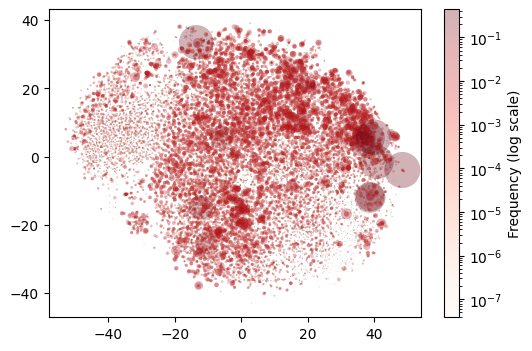

In [4]:
import matplotlib.colors as colors
from matplotlib.cm import ScalarMappable

freqs = occurrence_hist / occurrence_n_tokens

# plot the tsne again but weighted by frequency
frequencies = freqs
frequencies[frequencies == 0] = 1e-7

def normalize(frequencies):
    min_f = np.min(frequencies)
    max_f = np.max(frequencies)
    return (np.log(frequencies) - np.log(min_f)) / (np.log(max_f) - np.log(min_f))

plt.figure(figsize=(6, 4))

# Create a colormap (using the default grey colormap, not reversed)
cmap = plt.cm.Reds

# Create a normalization object
norm = colors.LogNorm(vmin=np.min(frequencies), vmax=np.max(frequencies))

# Create the scatter plot
scatter = plt.scatter(W_dec_tsne[:, 0], W_dec_tsne[:, 1], 
                s=frequencies*15e2, 
                c=frequencies,
                alpha=0.3,
                # next, add a border around the points
                edgecolor='black', linewidth=0.1,
                cmap=cmap, 
                norm=norm)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Frequency (log scale)')

In [5]:
# load cooccurrence clusters from disk
clustering_results_jaccard = np.load(f"../experiments/all-occurrences0/clusters/pile_{model.replace('/', '_')}_res_{sae_name.replace('/', '_')}_docs50k_keq256_cooccurrences_clusters.npz")
clustering_results_jaccard = {int(k): v for k, v in clustering_results_jaccard.items()}
n_clusterss = list(clustering_results_jaccard.keys())

In [6]:
clustering_results_ang = np.load(f"../experiments/all-occurrences0/clusters_ang/{repo_id.replace('/', '_')}_{sae_name.replace('/', '_')}_ang_sims_clusters.npz")
clustering_results_ang = {int(k): v for k, v in clustering_results_ang.items()}
n_clusterss_ang = list(clustering_results_ang.keys())

In [7]:
clustering_results_smc = np.load(f"../experiments/all-occurrences0/clusters_smc/pile_{model.replace('/', '_')}_res_{sae_name.replace('/', '_')}_docs50k_keq256_cooccurrences_smc_clusters.npz")
clustering_results_smc = {int(k): v for k, v in clustering_results_smc.items()}
n_clusterss = list(clustering_results_smc.keys())

In [8]:
clustering_results_dice = {}
for n_clusters in n_clusterss:
    clustering_results_dice[n_clusters] = np.load(f"../experiments/all-occurrences0/lily/dice/layer_12_{n_clusters}.npy")

In [9]:
clustering_results_overlap = {}
for n_clusters in n_clusterss:
    clustering_results_overlap[n_clusters] = np.load(f"../experiments/all-occurrences0/lily/overlap/layer_12_{n_clusters}.npy")

In [10]:
clustering_results_phi = {}
for n_clusters in n_clusterss:
    clustering_results_phi[n_clusters] = np.load(f"../experiments/all-occurrences0/lily/phi/layer_12_{n_clusters}.npy")

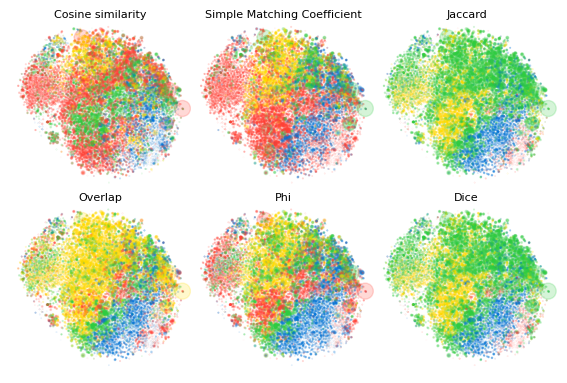

In [11]:
colors = ['#FF4136', '#0074D9', '#FFDC00', '#2ECC40', '#F012BE', 
          '#7FDBFF', '#FF851B', '#01FF70', '#B10DC9', '#FF69B4']

n_clusters = 4

plt.figure(figsize=(5.5, 5.5*2/3))

plt.subplot(2, 3, 1)

# ang
clusters = clustering_results_ang[n_clusters]
cperm = np.array([3, 2, 0, 1]) # permutation of {0, 1, 2, 3}, the lobe indices
cs = [colors[cperm[clusteri]] for clusteri in clusters]
cs = np.array(cs)
n_splits = 20
splits = np.array_split(np.random.permutation(len(clusters)), n_splits)
for split in splits:
    plt.scatter(W_dec_tsne[split, 0], W_dec_tsne[split, 1], 
        s=frequencies[split]*3e2,
        color=cs[split], 
        alpha=0.2)
plt.title(f"Cosine similarity", fontsize=8, pad=-10)
plt.axis('off')

plt.subplot(2, 3, 2)

# smc
clusters = clustering_results_smc[n_clusters]
cperm = np.array([3, 0, 2, 1]) # permutation of {0, 1, 2, 3}, the lobe indices
cs = [colors[cperm[clusteri]] for clusteri in clusters]
cs = np.array(cs)
n_splits = 20
splits = np.array_split(np.random.permutation(len(clusters)), n_splits)
for split in splits:
    plt.scatter(W_dec_tsne[split, 0], W_dec_tsne[split, 1], 
        s=frequencies[split]*3e2,
        color=cs[split], 
        alpha=0.2)
plt.title(f"Simple Matching Coefficient", fontsize=8, pad=-10)
plt.axis('off')


plt.subplot(2, 3, 3)

# jaccard
clusters = clustering_results_jaccard[n_clusters]
cperm = np.array([0, 3, 2, 1]) # permutation of {0, 1, 2, 3}, the lobe indices
cs = [colors[cperm[clusteri]] for clusteri in clusters]
cs = np.array(cs)
n_splits = 20
splits = np.array_split(np.random.permutation(len(clusters)), n_splits)
for split in splits:
    plt.scatter(W_dec_tsne[split, 0], W_dec_tsne[split, 1], 
        s=frequencies[split]*3e2,
        color=cs[split], 
        alpha=0.2)
plt.title(f"Jaccard", fontsize=8, pad=-10)
plt.axis('off')

plt.subplot(2, 3, 6)

# dice
clusters = clustering_results_dice[n_clusters]
cperm = np.array([3, 0, 1, 2]) # permutation of {0, 1, 2, 3}, the lobe indices
cs = [colors[cperm[clusteri]] for clusteri in clusters]
cs = np.array(cs)
n_splits = 20
splits = np.array_split(np.random.permutation(len(clusters)), n_splits)
for split in splits:
    plt.scatter(W_dec_tsne[split, 0], W_dec_tsne[split, 1], 
        s=frequencies[split]*3e2,
        color=cs[split], 
        alpha=0.2)
plt.title(f"Dice", fontsize=8, pad=-10)
plt.axis('off')

plt.subplot(2, 3, 4)

# overlap
clusters = clustering_results_overlap[n_clusters]
cperm = np.array([3, 2, 1, 0]) # permutation of {0, 1, 2, 3}, the lobe indices
cs = [colors[cperm[clusteri]] for clusteri in clusters]
cs = np.array(cs)
n_splits = 20
splits = np.array_split(np.random.permutation(len(clusters)), n_splits)
for split in splits:
    plt.scatter(W_dec_tsne[split, 0], W_dec_tsne[split, 1], 
        s=frequencies[split]*3e2,
        color=cs[split], 
        alpha=0.2)
plt.title(f"Overlap", fontsize=8, pad=-10)
plt.axis('off')

plt.subplot(2, 3, 5)

# phi
clusters = clustering_results_phi[n_clusters]
cperm = np.array([0, 1, 2, 3]) # permutation of {0, 1, 2, 3}, the lobe indices
cs = [colors[cperm[clusteri]] for clusteri in clusters]
cs = np.array(cs)
n_splits = 20
splits = np.array_split(np.random.permutation(len(clusters)), n_splits)
for split in splits:
    plt.scatter(W_dec_tsne[split, 0], W_dec_tsne[split, 1], 
        s=frequencies[split]*3e2,
        color=cs[split], 
        alpha=0.2)
plt.title(f"Phi", fontsize=8, pad=-10)
plt.axis('off')

plt.tight_layout(pad=0.1)

plt.savefig("lobe-comparisons.jpg", dpi=400)

In [12]:
# compute adjusted mutual information between all the clusterings
ami = defaultdict(list)

for n_clusters in tqdm(n_clusterss):
    ami['jaccard'].append(
        adjusted_mutual_info_score(
            clustering_results_ang[n_clusters], 
            clustering_results_jaccard[n_clusters]))
    ami['smc'].append(
        adjusted_mutual_info_score(
            clustering_results_ang[n_clusters], 
            clustering_results_smc[n_clusters]))
    ami['dice'].append(
        adjusted_mutual_info_score(
            clustering_results_ang[n_clusters], 
            clustering_results_dice[n_clusters]))
    ami['overlap'].append(
        adjusted_mutual_info_score(
            clustering_results_ang[n_clusters], 
            clustering_results_overlap[n_clusters]))
    ami['phi'].append(
        adjusted_mutual_info_score(
            clustering_results_ang[n_clusters], 
            clustering_results_phi[n_clusters]))


  0%|          | 0/10 [00:00<?, ?it/s]

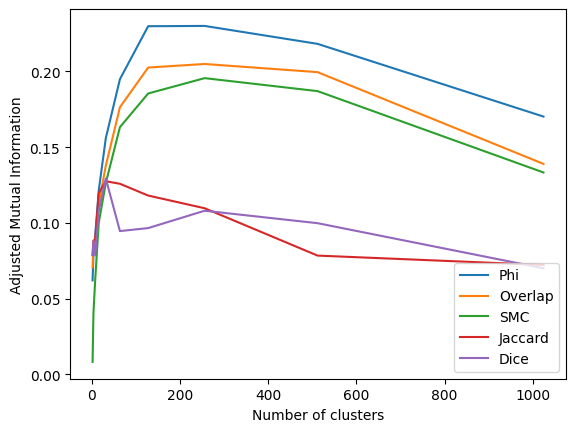

In [13]:
plt.plot(n_clusterss, ami['phi'], label='Phi')
plt.plot(n_clusterss, ami['overlap'], label='Overlap')
plt.plot(n_clusterss, ami['smc'], label='SMC')
plt.plot(n_clusterss, ami['jaccard'], label='Jaccard')
plt.plot(n_clusterss, ami['dice'], label='Dice')

plt.xlabel('Number of clusters')
plt.ylabel('Adjusted Mutual Information')
plt.legend(loc='lower right')

In [14]:
def fit_model(X, labels, split=0.8):
    train_labels, test_labels = labels[:int(len(labels)*split)], labels[int(len(labels)*split):]
    train_X, test_X = X[:int(len(labels)*split)], X[int(len(labels)*split):]
    clf = LogisticRegression(max_iter=1000).fit(train_X, train_labels)
    preds = clf.predict(test_X)
    return balanced_accuracy_score(test_labels, preds)

fit_results = defaultdict(list)
for n_clusters in tqdm(n_clusterss):
    # ang
    fit_results['ang'].append(fit_model(W_dec, clustering_results_ang[n_clusters]))
    # jaccard
    fit_results['jaccard'].append(fit_model(W_dec, clustering_results_jaccard[n_clusters]))
    # smc
    fit_results['smc'].append(fit_model(W_dec, clustering_results_smc[n_clusters]))
    # dice
    fit_results['dice'].append(fit_model(W_dec, clustering_results_dice[n_clusters]))
    # overlap
    fit_results['overlap'].append(fit_model(W_dec, clustering_results_overlap[n_clusters]))
    # phi
    fit_results['phi'].append(fit_model(W_dec, clustering_results_phi[n_clusters]))


  0%|          | 0/10 [00:00<?, ?it/s]

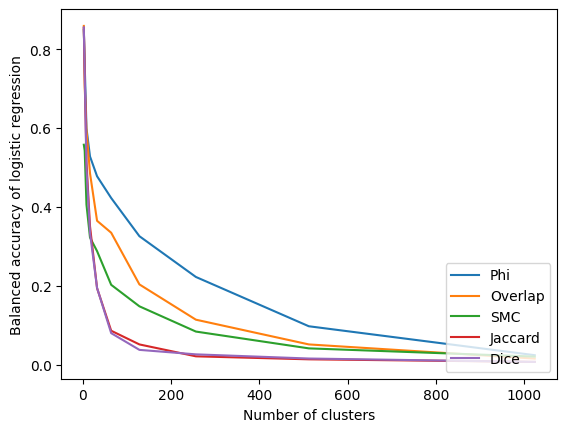

In [15]:
plt.plot(n_clusterss, fit_results['phi'], label='Phi')
plt.plot(n_clusterss, fit_results['overlap'], label='Overlap')
plt.plot(n_clusterss, fit_results['smc'], label='SMC')
plt.plot(n_clusterss, fit_results['jaccard'], label='Jaccard')
plt.plot(n_clusterss, fit_results['dice'], label='Dice')

plt.xlabel('Number of clusters')
plt.ylabel('Balanced accuracy of logistic regression')
plt.legend(loc='lower right')

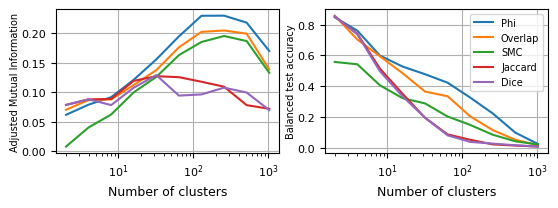

In [17]:
plt.figure(figsize=(5.5, 2.0))

# First subplot
plt.subplot(1, 2, 1)
# Adjusted MI
plt.plot(n_clusterss, ami['phi'], label='Phi')
plt.plot(n_clusterss, ami['overlap'], label='Overlap')
plt.plot(n_clusterss, ami['smc'], label='SMC')
plt.plot(n_clusterss, ami['jaccard'], label='Jaccard')
plt.plot(n_clusterss, ami['dice'], label='Dice')
plt.xlabel('Number of clusters', fontsize=9)
plt.ylabel('Adjusted Mutual Information', fontsize=7, labelpad=1)
# plt.legend(loc='lower right', fontsize=7)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xscale('log')
plt.grid(True)

# Second subplot
plt.subplot(1, 2, 2)
# Fit
plt.plot(n_clusterss, fit_results['phi'], label='Phi')
plt.plot(n_clusterss, fit_results['overlap'], label='Overlap')
plt.plot(n_clusterss, fit_results['smc'], label='SMC')
plt.plot(n_clusterss, fit_results['jaccard'], label='Jaccard')
plt.plot(n_clusterss, fit_results['dice'], label='Dice')
plt.xlabel('Number of clusters', fontsize=9)
plt.ylabel('Balanced test accuracy', fontsize=7, labelpad=1)
plt.legend(loc='upper right', fontsize=7)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xscale('log')
plt.grid(True)

plt.tight_layout(pad=0.4)
# remove some of the bottom of the plot
# plt.subplots_adjust(bottom=0.01)
# plt.savefig("cluster-comparisons.pdf")

In [18]:
# do monte-carlo simulation of logistic regression performance for random features
# let's just do phi for now, with n_clusters = 2

n_clusters = 2
n_trials = 100
fit_results_random = []
for _ in tqdm(range(n_trials)):
    random_features = np.random.randn(*W_dec.shape)
    random_features /= np.linalg.norm(random_features, axis=1)[:, None]
    fit_results_random.append(fit_model(random_features, clustering_results_phi[n_clusters]))

  0%|          | 0/100 [00:00<?, ?it/s]

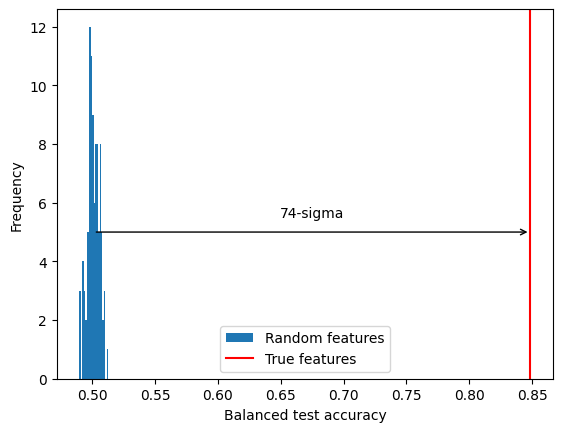

In [19]:
# plot histogram of balanced accuracies under random features
_ = plt.hist(fit_results_random, bins=20, label='Random features')
# compute population std dev of balanced accuracies under random features
std_dev = np.std(fit_results_random)
mean = np.mean(fit_results_random)
true = fit_results['phi'][n_clusterss.index(n_clusters)]
# print((true-mean)/std_dev)
# print(std_dev)
# plot vertical line of phi balanced accuracy with true features
plt.axvline(true, color='red', label='True features')
# draw arrow from mean to true
plt.annotate('', xy=(true, 5), xytext=(mean, 5), arrowprops=dict(arrowstyle='->'))
# annotate with text of z-score
plt.text(mean + (true - mean)/2, 5.5, f'{((true-mean)/std_dev):.0f}-sigma', horizontalalignment='center')
plt.xlabel('Balanced test accuracy')
plt.ylabel('Frequency')
plt.legend()

In [20]:
# run monte-carlo on adjusted MI calculation, with random permutations of labels
n_trials = 100
ami_random = []
for _ in tqdm(range(n_trials)):
    ami_random.append(
        adjusted_mutual_info_score(
            np.random.permutation(clustering_results_ang[n_clusters]),
            clustering_results_phi[n_clusters]))

  0%|          | 0/100 [00:00<?, ?it/s]

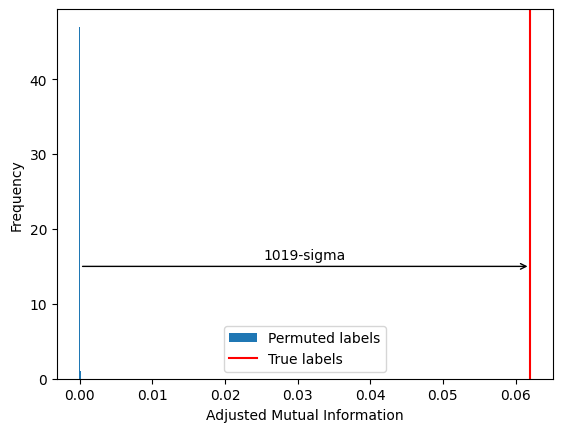

In [21]:
# plot histogram of balanced accuracies under random features
_ = plt.hist(ami_random, bins=20, label='Permuted labels')
# compute population std dev of balanced accuracies under random features
std_dev = np.std(ami_random)
mean = np.mean(ami_random)
true = ami['phi'][n_clusterss.index(n_clusters)]
# print((true-mean)/std_dev)
# print(std_dev)
# plot vertical line of phi balanced accuracy with true features
plt.axvline(true, color='red', label='True labels')
# draw arrow from mean to true
plt.annotate('', xy=(true, 15), xytext=(mean, 15), arrowprops=dict(arrowstyle='->'))
# annotate with text of z-score
plt.text(mean + (true - mean)/2, 16, f'{((true-mean)/std_dev):.0f}-sigma', horizontalalignment='center')
plt.xlabel('Adjusted Mutual Information')
plt.ylabel('Frequency')
plt.legend()

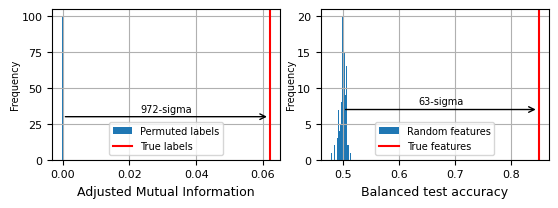

In [87]:
plt.figure(figsize=(5.5, 2.0))

# First subplot
plt.subplot(1, 2, 1)
# Adjusted MI
# plot histogram of balanced accuracies under random features
_ = plt.hist(ami_random, bins=1, label='Permuted labels')
# compute population std dev of balanced accuracies under random features
std_dev = np.std(ami_random)
mean = np.mean(ami_random)
true = ami['phi'][n_clusterss.index(n_clusters)]
# plot vertical line of phi balanced accuracy with true features
plt.axvline(true, color='red', label='True labels')
# draw arrow from mean to true
plt.annotate('', xy=(true, 30), xytext=(mean, 30), arrowprops=dict(arrowstyle='->'))
# annotate with text of z-score
plt.text(mean + (true - mean)/2, 33, f'{((true-mean)/std_dev):.0f}-sigma', horizontalalignment='center', fontsize=7)
plt.xlabel('Adjusted Mutual Information', fontsize=9)
plt.ylabel('Frequency', fontsize=7, labelpad=1)
plt.legend(fontsize=7)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
# plt.yscale('log')
plt.grid(True)

# Second subplot
plt.subplot(1, 2, 2)
# plot histogram of balanced accuracies under random features
_ = plt.hist(fit_results_random, bins=20, label='Random features')
# compute population std dev of balanced accuracies under random features
std_dev = np.std(fit_results_random)
mean = np.mean(fit_results_random)
true = fit_results['phi'][n_clusterss.index(n_clusters)]
# plot vertical line of phi balanced accuracy with true features
plt.axvline(true, color='red', label='True features')
# draw arrow from mean to true
plt.annotate('', xy=(true, 7), xytext=(mean, 7), arrowprops=dict(arrowstyle='->'))
# annotate with text of z-score
plt.text(mean + (true - mean)/2, 7.8, f'{((true-mean)/std_dev):.0f}-sigma', horizontalalignment='center', fontsize=7)
plt.xlabel('Balanced test accuracy', fontsize=9)
plt.ylabel('Frequency', fontsize=7, labelpad=1)
plt.legend(fontsize=7)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid(True)

plt.tight_layout(pad=0.4)
plt.savefig("random-comparisons.pdf")

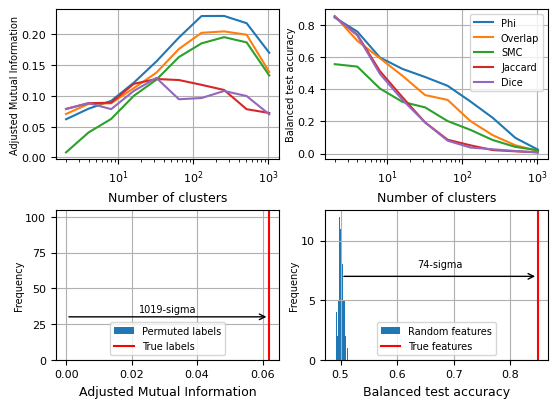

In [23]:
plt.figure(figsize=(5.5, 4))

# First subplot
plt.subplot(2, 2, 1)
# Adjusted MI
plt.plot(n_clusterss, ami['phi'], label='Phi')
plt.plot(n_clusterss, ami['overlap'], label='Overlap')
plt.plot(n_clusterss, ami['smc'], label='SMC')
plt.plot(n_clusterss, ami['jaccard'], label='Jaccard')
plt.plot(n_clusterss, ami['dice'], label='Dice')
plt.xlabel('Number of clusters', fontsize=9)
plt.ylabel('Adjusted Mutual Information', fontsize=7, labelpad=1)
# plt.legend(loc='lower right', fontsize=7)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xscale('log')
plt.grid(True)

# Second subplot
plt.subplot(2, 2, 2)
# Fit
plt.plot(n_clusterss, fit_results['phi'], label='Phi')
plt.plot(n_clusterss, fit_results['overlap'], label='Overlap')
plt.plot(n_clusterss, fit_results['smc'], label='SMC')
plt.plot(n_clusterss, fit_results['jaccard'], label='Jaccard')
plt.plot(n_clusterss, fit_results['dice'], label='Dice')
plt.xlabel('Number of clusters', fontsize=9)
plt.ylabel('Balanced test accuracy', fontsize=7, labelpad=1)
plt.legend(loc='upper right', fontsize=7)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xscale('log')
plt.grid(True)


# First subplot
plt.subplot(2, 2, 3)
# Adjusted MI
# plot histogram of balanced accuracies under random features
_ = plt.hist(ami_random, bins=1, label='Permuted labels')
# compute population std dev of balanced accuracies under random features
std_dev = np.std(ami_random)
mean = np.mean(ami_random)
true = ami['phi'][n_clusterss.index(n_clusters)]
# plot vertical line of phi balanced accuracy with true features
plt.axvline(true, color='red', label='True labels')
# draw arrow from mean to true
plt.annotate('', xy=(true, 30), xytext=(mean, 30), arrowprops=dict(arrowstyle='->'))
# annotate with text of z-score
plt.text(mean + (true - mean)/2, 33, f'{((true-mean)/std_dev):.0f}-sigma', horizontalalignment='center', fontsize=7)
plt.xlabel('Adjusted Mutual Information', fontsize=9)
plt.ylabel('Frequency', fontsize=7, labelpad=1)
plt.legend(fontsize=7)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
# plt.yscale('log')
plt.grid(True)

# Second subplot
plt.subplot(2, 2, 4)
# plot histogram of balanced accuracies under random features
_ = plt.hist(fit_results_random, bins=20, label='Random features')
# compute population std dev of balanced accuracies under random features
std_dev = np.std(fit_results_random)
mean = np.mean(fit_results_random)
true = fit_results['phi'][n_clusterss.index(n_clusters)]
# plot vertical line of phi balanced accuracy with true features
plt.axvline(true, color='red', label='True features')
# draw arrow from mean to true
plt.annotate('', xy=(true, 7), xytext=(mean, 7), arrowprops=dict(arrowstyle='->'))
# annotate with text of z-score
plt.text(mean + (true - mean)/2, 7.8, f'{((true-mean)/std_dev):.0f}-sigma', horizontalalignment='center', fontsize=7)
plt.xlabel('Balanced test accuracy', fontsize=9)
plt.ylabel('Frequency', fontsize=7, labelpad=1)
plt.legend(fontsize=7)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid(True)


plt.tight_layout(pad=0.4)
# # remove some of the bottom of the plot
# # plt.subplots_adjust(bottom=0.01)
plt.savefig("affinity-comparisons-four.pdf")

In [47]:
random_features = np.random.randn(*W_dec.shape)
# make rows unit norm
random_features /= np.linalg.norm(random_features, axis=1)[:, None]

In [48]:
np.linalg.norm(random_features, axis=1).shape

(16384,)

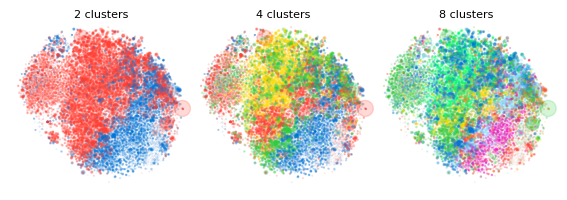

In [40]:
colors = ['#FF4136', '#0074D9', '#FFDC00', '#2ECC40', '#F012BE', 
          '#7FDBFF', '#FF851B', '#01FF70', '#B10DC9', '#FF69B4']

n_clusterss_plot = [2, 4, 8]

plt.figure(figsize=(5.5, 5.5*1/3))

for i, n_clusters in enumerate(n_clusterss_plot):
    plt.subplot(1, 3, i+1)

    clusters = clustering_results_phi[n_clusters]
    cs = [colors[clusteri] for clusteri in clusters]
    cs = np.array(cs)
    n_splits = 20
    splits = np.array_split(np.random.permutation(len(clusters)), n_splits)
    for split in splits:
        plt.scatter(W_dec_tsne[split, 0], W_dec_tsne[split, 1], 
            s=frequencies[split]*3e2,
            color=cs[split], 
            alpha=0.2)
    plt.title(f"{n_clusters} clusters", fontsize=8, pad=-10)
    plt.axis('off')

plt.tight_layout(pad=0.1)

plt.savefig("lobes-2-4-8-phi.png", dpi=400)

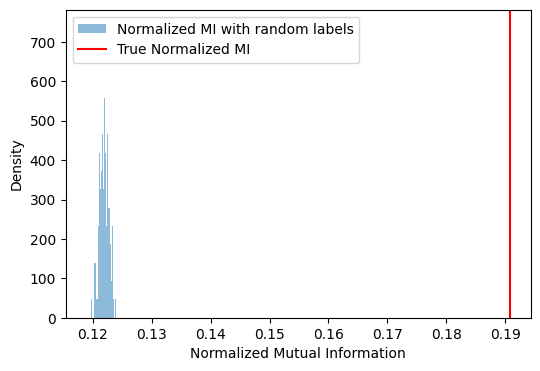

In [21]:
# plot histogram over randomized mutual information scores for n_clusters = 256
plt.figure(figsize=(6, 4))
n_clusters = 512
plt.hist(random_normalized_mis[n_clusters], bins=50, alpha=0.5, label='Normalized MI with random labels', density=True)
plt.axvline(normalized_mis[n_clusterss.index(n_clusters)], color='r', label='True Normalized MI')
plt.xlabel("Normalized Mutual Information")
plt.ylabel("Density")
plt.legend(loc='upper left')

In [ ]:
"""
does smc score suffer from same issue as jaccard?
independent features with 0.1 probability of being on:
smc = (0.1 * 0.1 + 0.9 * 0.9): 0.82
independent features with 0.01 probability of being on:
smc = (0.01 * 0.01 + 0.99 * 0.99): 0.9802
"""